# Import modules

In [1]:
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
import pickle
import keras_tuner as kt
import tensorflow as tf

from scipy.signal import butter, lfilter
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import recall_score, accuracy_score, precision_score, plot_confusion_matrix,classification_report
from sklearn import preprocessing
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Flatten, Dropout, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# Path

In [2]:
train_path = 'dataset/train/train/'
test_path = 'dataset/test/test/'

# Visualization of a sound file

In [3]:
def show_voice(path):
    data, samplerate = sf.read(path)
    plt.plot(data)
    plt.show()
    return data, samplerate

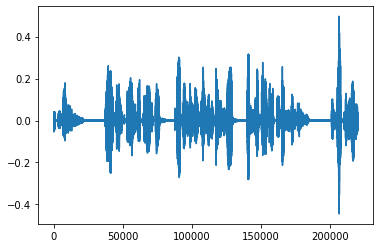

In [4]:
filename = 'de_f_5d2e7f30d69f2d1d86fd05f3bbe120c2.fragment1.flac'
signal, sr = show_voice(train_path+filename)

# MFCC feature extraction

### Normal MFCC

In [5]:
mfcc = librosa.feature.mfcc(signal, n_mfcc=5, sr = sr)
mfcc.shape

C:\Users\Dell\AppData\Local\Temp/ipykernel_15280/1687431471.py:1: FutureWarning: Pass y=[ 0.01663208 -0.01715088  0.00863647 ...  0.00540161  0.00170898
  0.00082397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal, n_mfcc=5, sr = sr)


(5, 431)

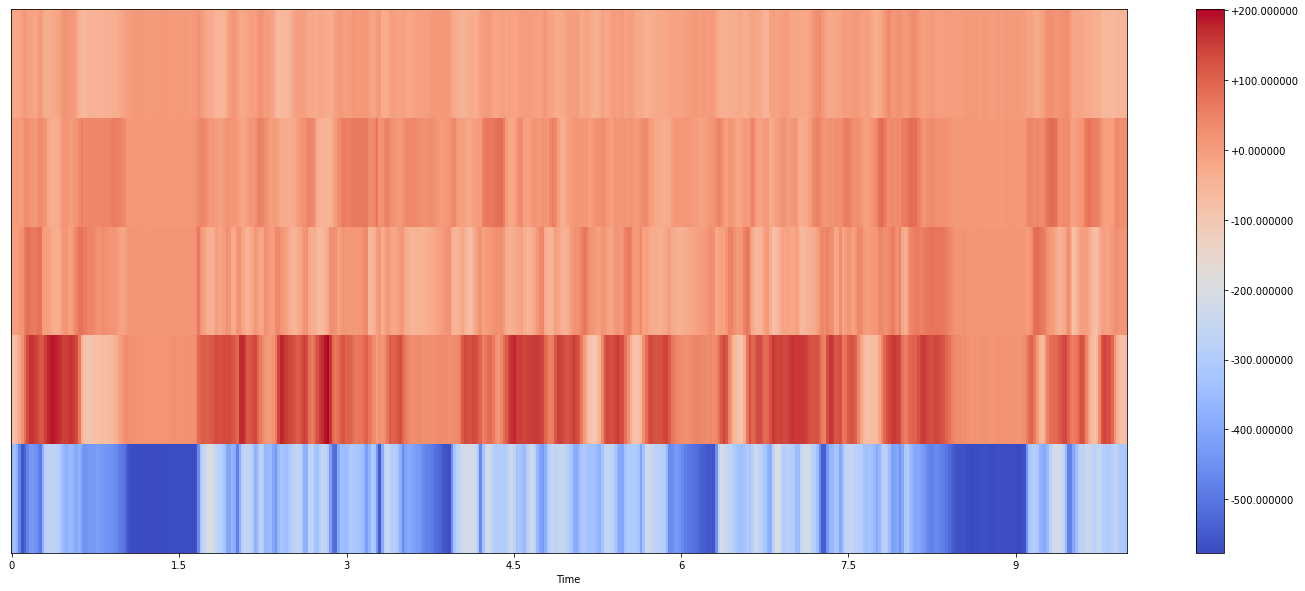

In [6]:
# Visualization of MFCC

plt.figure(figsize=(25,10))
librosa.display.specshow(mfcc, x_axis="time", sr=sr)
plt.colorbar(format="%+2f")
plt.show()

### Delta MFCC

In [7]:
delta_mfcc = librosa.feature.delta(mfcc)
delta_mfcc.shape

(5, 431)

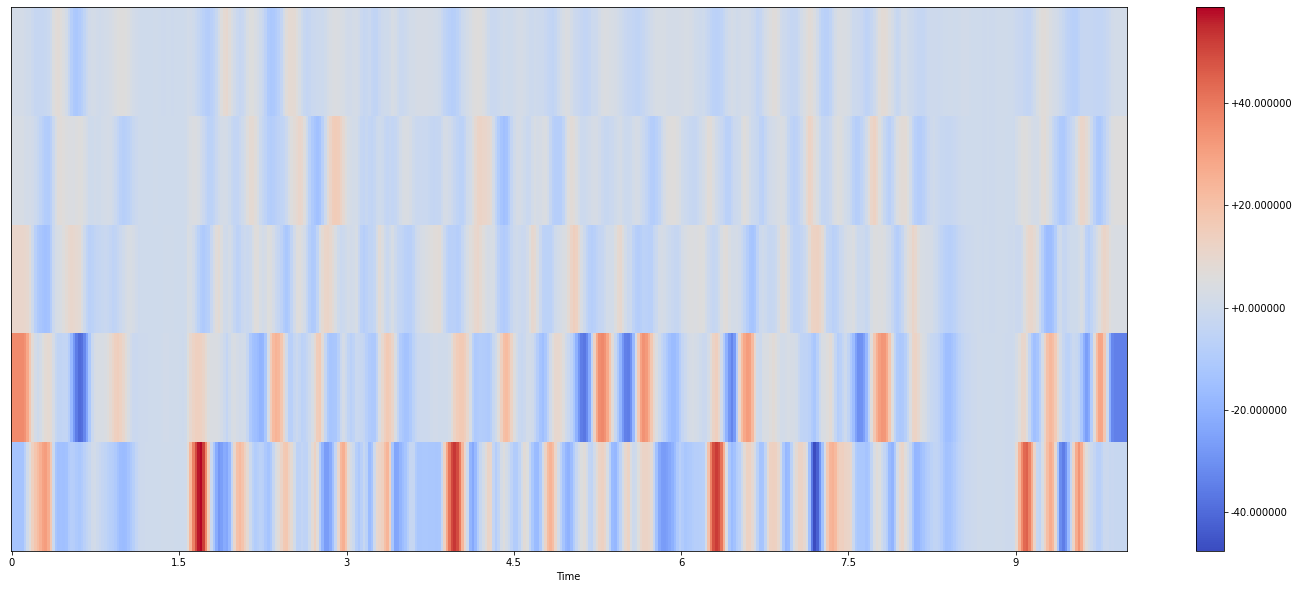

In [8]:
# Visualization of delta MFCC

plt.figure(figsize=(25,10))
librosa.display.specshow(delta_mfcc, x_axis="time", sr=sr)
plt.colorbar(format="%+2f")
plt.show()

### Delta 2 MFCC

In [9]:
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
delta2_mfcc.shape

(5, 431)

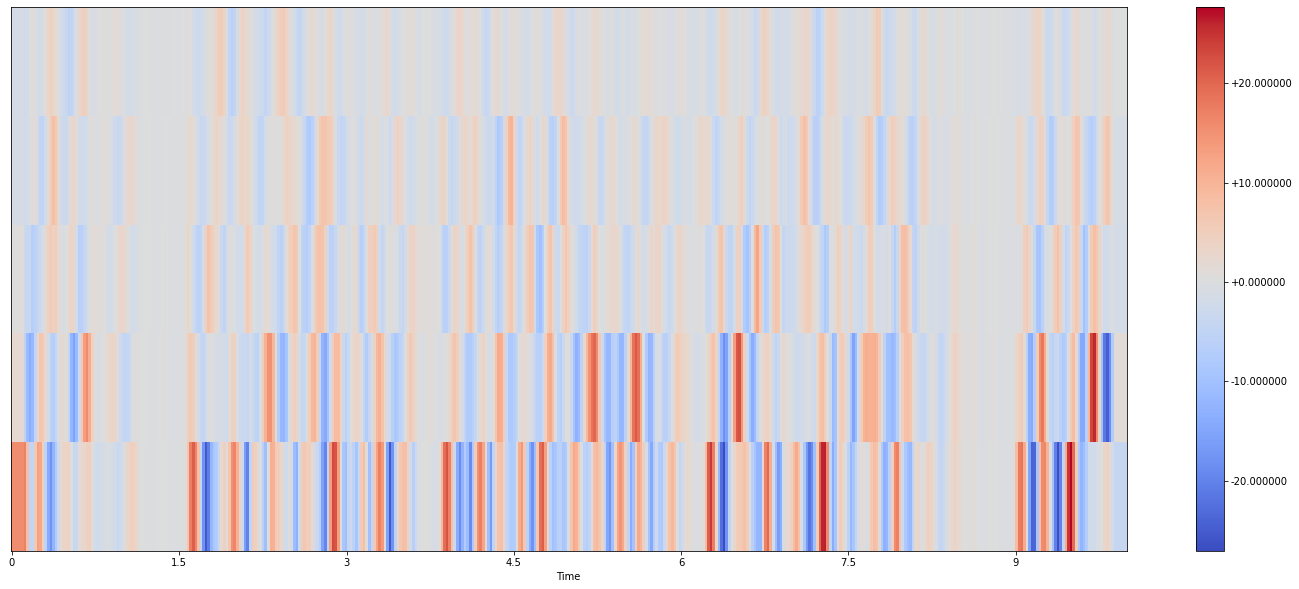

In [10]:
# Visualization of delta2 MFCC

plt.figure(figsize=(25,10))
librosa.display.specshow(delta2_mfcc, x_axis="time", sr=sr)
plt.colorbar(format="%+2f")
plt.show()

### Combining all MFCC

In [11]:
combined_mfccs = np.concatenate((mfcc, delta_mfcc, delta2_mfcc))
combined_mfccs = np.mean(combined_mfccs.T,axis=0)
combined_mfccs.shape

(15,)

# Preprocessing MFCC features

### Normalization of audio

In [12]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

### Filtering the noise

In [13]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

### Combining MFCC

In [14]:
def get_mfcc(signal, sr):
    mfcc = librosa.feature.mfcc(signal, n_mfcc=5, sr = sr)
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    combined_mfccs = np.concatenate((mfcc, delta_mfcc, delta2_mfcc))
    combined_mfccs = np.mean(combined_mfccs.T,axis=0)
  
    return combined_mfccs

# Converting the features to csv file

In [15]:
def proprocess_and_convert_to_csv(converted_file_name,data_path):
    
    gender_list = []
    language_list = []
    sound_list = []
    lowcut = 300
    highcut = 3000
    raw_data = {
    'language':language_list,
    'gender':gender_list,
    'sound': sound_list}
    df_data = pd.DataFrame(raw_data)
    
    for filename in os.listdir(data_path):
        language = filename[:2]
        gender = 'male' if filename[3:4] == 'm' else 'female'
        data, sr = sf.read(data_path + filename)
        data_nor = normalize_audio(data)
        filtered_data = butter_bandpass_filter(data_nor, lowcut, highcut, sr, order=5)
        mfcc = get_mfcc(filtered_data,sr)
        gender_list.append(gender)
        language_list.append(language)
        sound_list.append(mfcc) 

    df_data['sound']=sound_list
    df_data['gender'] = gender_list
    df_data['language'] = language_list

    df_data.to_csv(converted_file_name,index=False)
    return df_data


In [16]:
%mkdir output

A subdirectory or file output already exists.


In [17]:
import warnings
warnings.filterwarnings('ignore')

#df_data_raw = proprocess_and_convert_to_csv("output/SLI_train.csv",train_path)
df_data_raw = proprocess_and_convert_to_csv("output/SLI_test.csv",test_path)

### Splitting the sound features into seperate columns

In [18]:
sound_features = [i for i in range(len(df_data_raw['sound'].to_list()[0]))]
df_data_raw[sound_features] = pd.DataFrame(df_data_raw['sound'].to_list(), index= df_data_raw.index)
df_data = df_data_raw.drop(columns=['sound'])

# One hot encoder

### Data visualization before encoding

In [19]:
df_data.head()

,language,gender,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,de,female,-315.038436,118.270345,-53.995252,-3.579302,-2.136428,-0.026528,-0.092722,0.068485,0.117757,0.091901,0.059692,-0.051885,0.035770,0.108130,0.015017
1,de,female,-309.297124,117.565845,-59.202830,6.795520,1.341668,-0.398150,-0.115267,0.232833,-0.031711,-0.028919,-0.109100,0.033349,0.082398,-0.075694,-0.005597
2,de,female,-328.725292,94.802323,-36.108947,4.210060,1.520972,0.062456,0.021131,0.074125,-0.019996,-0.039309,0.206890,0.076695,-0.009012,0.015138,0.003152
3,de,female,-313.997358,104.255598,-48.787727,5.023298,-0.575214,-0.173627,-0.261625,-0.132671,0.137602,0.192857,0.199135,0.036002,-0.154692,0.020720,0.054311
4,de,female,-332.545660,96.303017,-42.728825,0.184300,-2.106077,0.436070,0.323886,-0.108979,-0.205109,-0.118843,-0.034784,0.030971,0.054020,-0.022050,0.009418


### Encoding

In [20]:
one_hot_gender = pd.get_dummies(df_data['gender'])
df_data = df_data.drop('gender',axis = 1)
df_data = df_data.join(one_hot_gender)

one_hot_encoder = OneHotEncoder()
one_hot_language = one_hot_encoder.fit_transform(df_data['language'].to_numpy().reshape(-1, 1))
one_hot_language_df = pd.DataFrame(one_hot_language.toarray(), columns=one_hot_encoder.get_feature_names())
df_data = pd.concat([df_data, one_hot_language_df], axis=1)

### Visualization after encoding

In [21]:
df_data.head()

,language,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,female,male,x0_de,x0_en,x0_es
0,de,-315.038436,118.270345,-53.995252,-3.579302,-2.136428,-0.026528,-0.092722,0.068485,0.117757,...,0.059692,-0.051885,0.035770,0.108130,0.015017,1,0,1.0,0.0,0.0
1,de,-309.297124,117.565845,-59.202830,6.795520,1.341668,-0.398150,-0.115267,0.232833,-0.031711,...,-0.109100,0.033349,0.082398,-0.075694,-0.005597,1,0,1.0,0.0,0.0
2,de,-328.725292,94.802323,-36.108947,4.210060,1.520972,0.062456,0.021131,0.074125,-0.019996,...,0.206890,0.076695,-0.009012,0.015138,0.003152,1,0,1.0,0.0,0.0
3,de,-313.997358,104.255598,-48.787727,5.023298,-0.575214,-0.173627,-0.261625,-0.132671,0.137602,...,0.199135,0.036002,-0.154692,0.020720,0.054311,1,0,1.0,0.0,0.0
4,de,-332.545660,96.303017,-42.728825,0.184300,-2.106077,0.436070,0.323886,-0.108979,-0.205109,...,-0.034784,0.030971,0.054020,-0.022050,0.009418,1,0,1.0,0.0,0.0


# Spiltting data into training and testing

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_data.drop(columns=['language','x0_de','x0_en','x0_es'] ), df_data[['language','x0_de','x0_en','x0_es']], test_size=0.3, random_state = np.random.seed(60))

# seperate train data into 2 sets 'onehot' and 'original string'
y_train_onehot = y_train.drop(columns=['language'])
y_train_string = y_train.drop(columns=['x0_de','x0_en','x0_es'] )

# seperate test data into 2 sets 'onehot' and 'original string'
y_test_onehot = y_test.drop(columns=['language'])
y_test_string = y_test.drop(columns=['x0_de','x0_en','x0_es'] )

In [23]:
print(y_test_string)

    language
150       de
339       en
126       de
15        de
200       en
..       ...
192       en
383       es
219       en
138       de
502       es

[162 rows x 1 columns]


In [24]:
# Saving for website backend (Optional)

df_train = pd.DataFrame(X_train)
df_test = pd.DataFrame(X_test)
df_train.to_csv("webapp/models/train.csv",index=False)
df_test.to_csv("webapp/models/test.csv",index=False)

# Standardizing and scaling train data

In [25]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM model

### Fitting dataset into model

In [26]:
clf = SVC(kernel='linear')
clf.fit(X_train,y_train_string)
y_pred_string = clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test_string, y_pred_string))
print('Precision =',precision_score(y_test_string, y_pred_string, average=None))
print('Recall =',recall_score(y_test_string, y_pred_string, average=None))

Accuracy = 0.9320987654320988
Precision = [0.90384615 0.96226415 0.92982456]
Recall = [1.         0.85       0.96363636]


### Plotting confusion matrix

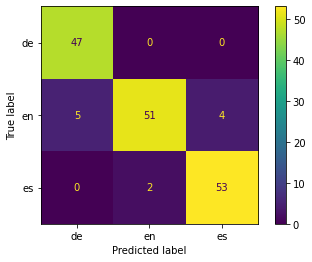

In [27]:
plot_confusion_matrix(clf, X_test, y_test_string)

# Tuning

### Fitting dataset using GridSearchCV

In [28]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=1)
grid.fit(X_train,y_train_string)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

### Plotting results of GridSearchCV

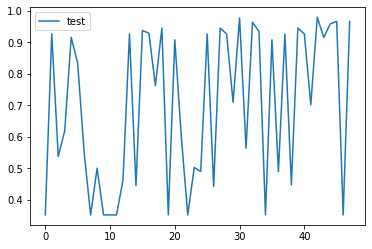

In [29]:
test_scores = grid.cv_results_['mean_test_score']

plt.plot(test_scores, label='test')
plt.legend(loc='best')
plt.show()

In [30]:
print(grid.best_params_)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [31]:
tuned_predictions = grid.predict(X_test)
print('Accuracy =', accuracy_score(y_test_string,tuned_predictions))
print('Precision =',precision_score(y_test_string, tuned_predictions, average=None))
print('Recall =',recall_score(y_test_string, tuned_predictions, average=None))

Accuracy = 0.9753086419753086
Precision = [0.94       1.         0.98181818]
Recall = [1.         0.95       0.98181818]


### Plotting confusion matrix

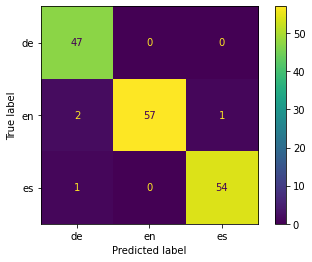

In [32]:
plot_confusion_matrix(grid, X_test, y_test_string)

In [33]:
print('Accuracy for SVM tuned model is:', accuracy_score(y_test_string, tuned_predictions))
print('precision',precision_score(y_test_string, tuned_predictions, average=None))
print('recall',recall_score(y_test_string, tuned_predictions, average=None))

Accuracy for SVM tuned model is: 0.9753086419753086
precision [0.94       1.         0.98181818]
recall [1.         0.95       0.98181818]


In [34]:
svm_saved = "webapp/models/svm.sav"
pickle.dump(grid, open(svm_saved,"wb"))

## NNMLP

In [35]:
def mlp_model_builder():
    # initial model
    model = Sequential()
    model.add(Dense(17, input_dim=17, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Configure the model and start training
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [36]:
mlp_model = mlp_model_builder()
mlp_model_history = mlp_model.fit(X_train, y_train_onehot,validation_split=0.1, epochs=100, batch_size=30, verbose=1)

Epoch 1/100
12/12 [==============================] - 1s 16ms/step - loss: 1.0825 - accuracy: 0.3765 - val_loss: 1.1957 - val_accuracy: 0.3684
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0371 - accuracy: 0.3941 - val_loss: 1.1385 - val_accuracy: 0.3684
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 1.0013 - accuracy: 0.4235 - val_loss: 1.0935 - val_accuracy: 0.3947
Epoch 4/100
12/12 [==============================] - 0s 3ms/step - loss: 0.9709 - accuracy: 0.4559 - val_loss: 1.0579 - val_accuracy: 0.4211
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.9442 - accuracy: 0.4647 - val_loss: 1.0243 - val_accuracy: 0.4211
Epoch 6/100
12/12 [==============================] - 0s 4ms/step - loss: 0.9199 - accuracy: 0.5176 - val_loss: 0.9931 - val_accuracy: 0.4737
Epoch 7/100
12/12 [==============================] - 0s 4ms/step - loss: 0.8965 - accuracy: 0.5471 - val_loss: 0.9660 - val_accuracy: 0.5000
Epoch 8/100


Epoch 59/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3242 - accuracy: 0.8176 - val_loss: 0.4149 - val_accuracy: 0.7368
Epoch 60/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3205 - accuracy: 0.8176 - val_loss: 0.4130 - val_accuracy: 0.7368
Epoch 61/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3152 - accuracy: 0.8176 - val_loss: 0.4040 - val_accuracy: 0.7368
Epoch 62/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3105 - accuracy: 0.8176 - val_loss: 0.3991 - val_accuracy: 0.7368
Epoch 63/100
12/12 [==============================] - 0s 3ms/step - loss: 0.3064 - accuracy: 0.8176 - val_loss: 0.3983 - val_accuracy: 0.7368
Epoch 64/100
12/12 [==============================] - 0s 4ms/step - loss: 0.3014 - accuracy: 0.8176 - val_loss: 0.3958 - val_accuracy: 0.7368
Epoch 65/100
12/12 [==============================] - 0s 4ms/step - loss: 0.2966 - accuracy: 0.8206 - val_loss: 0.3906 - val_accuracy: 0.7368
Epoch 

In [37]:
y_pred_onehot = mlp_model.predict(X_test)
predect_string_mlp = one_hot_encoder.inverse_transform(y_pred_onehot)
accuracy_basic_mlp = accuracy_score(y_test_string, predect_string_mlp)
print('Accuracy for MLP model is:', accuracy_basic_mlp)

Accuracy for MLP model is: 0.9506172839506173


In [38]:
print('Accuracy for MLP model is:', accuracy_score(y_test_string, predect_string_mlp))
print('precision',precision_score(y_test_string, predect_string_mlp, average=None))
print('recall',recall_score(y_test_string, predect_string_mlp, average=None))

Accuracy for MLP model is: 0.9506172839506173
precision [0.97916667 0.93333333 0.94444444]
recall [1.         0.93333333 0.92727273]


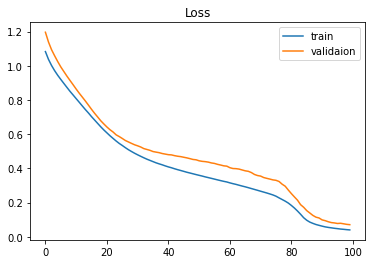

In [39]:
plt.title('Loss')
plt.plot(mlp_model_history.history['loss'], label='train')
plt.plot(mlp_model_history.history['val_loss'], label='validaion')
plt.legend()
plt.show();

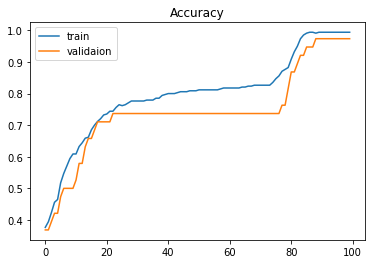

In [40]:
plt.title('Accuracy')
plt.plot(mlp_model_history.history['accuracy'], label='train')
plt.plot(mlp_model_history.history['val_accuracy'], label='validaion')
plt.legend()
plt.show();

Text(0.5, 0, 'epoch')

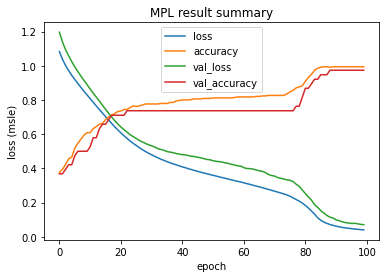

In [41]:
loss_df_mlp = pd.DataFrame(mlp_model_history.history)
loss_df_mlp.plot()
plt.title('MPL result summary')
plt.ylabel('loss (msle)')
plt.xlabel('epoch')

In [42]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                306       
                                                                 
 dense_1 (Dense)             (None, 5)                 90        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 414
Trainable params: 414
Non-trainable params: 0
_________________________________________________________________


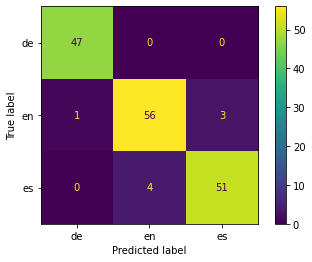

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_mlp = confusion_matrix(y_test_string, predect_string_mlp,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['de','en','es'])
disp.plot()

##### Tuning

In [44]:
def mlp_tuned_builder(hp):
    model = Sequential()
    model.add(Dense(17, input_dim=17, activation='relu'))
    for i in range(hp.Int('layers', 0, 4)):
      # Tune the number of units in the layer (between 5 to 12)
      # Tune the activation function ('relu', 'sigmoid', 'tanh')
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i), 5, 12, step=2),
                                      activation=hp.Choice('act_' + str(i), ['relu', 'sigmoid', 'tanh'])))
    model.add(Dense(3, activation='softmax'))

    # Tune the learning rate in the optimizer (between 0.01, 0.001, 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=hp_learning_rate), 
                  metrics=['accuracy'])
    return model

tuner = kt.Hyperband(mlp_tuned_builder,
                     objective='accuracy',
                     max_epochs=40,
                     directory='output/mlp_keras_tuner_dir',
                     project_name='mlp_keras_tuner')

INFO:tensorflow:Reloading Oracle from existing project output/mlp_keras_tuner_dir\mlp_keras_tuner\oracle.json
INFO:tensorflow:Reloading Tuner from output/mlp_keras_tuner_dir\mlp_keras_tuner\tuner0.json


In [45]:
%mkdir logs

A subdirectory or file logs already exists.


In [46]:
tuner.search(X_train, 
      y_train_onehot,
      epochs=50,
      batch_size=30,
      validation_split=0.1,
      callbacks = [keras.callbacks.TensorBoard("/IT351_project/logs/tb_mlp_logs")],
      verbose=2)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Get the tuner summary
tuner.results_summary()

INFO:tensorflow:Oracle triggered exit
Results summary
Results in output/mlp_keras_tuner_dir\mlp_keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 2
learning_rate: 0.01
units_0: 11
act_0: relu
units_1: 11
act_1: relu
tuner/epochs: 14
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0035
Score: 1.0
Trial summary
Hyperparameters:
layers: 2
learning_rate: 0.01
units_0: 11
act_0: relu
units_1: 9
act_1: relu
units_2: 7
act_2: sigmoid
units_3: 7
act_3: tanh
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 1.0
Trial summary
Hyperparameters:
layers: 1
learning_rate: 0.01
units_0: 9
act_0: relu
units_1: 7
act_1: tanh
units_2: 9
act_2: tanh
units_3: 11
act_3: relu
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0069
Score: 1.0
Trial summary
Hyperparameters:
layers: 2
learning_rate: 0.01
units_0: 11
act_0: tanh
units_1: 7
act_1: tanh
units_2: 7
act_2: tanh
unit

In [47]:
# Get the best model summary
mlp_best_model = tuner.hypermodel.build(best_hps)
mlp_best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 17)                306       
                                                                 
 dense_6 (Dense)             (None, 11)                198       
                                                                 
 dense_7 (Dense)             (None, 11)                132       
                                                                 
 dense_8 (Dense)             (None, 3)                 36        
                                                                 
Total params: 672
Trainable params: 672
Non-trainable params: 0
_________________________________________________________________


In [48]:
mlp_tuned_model_history = mlp_best_model.fit(
    X_train, 
    y_train_onehot,
    epochs=100,
    batch_size=50
)

Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 1.0845 - accuracy: 0.3439
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 0.9138 - accuracy: 0.5979
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 0.6821 - accuracy: 0.7222
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 0.4919 - accuracy: 0.7937
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 0.2830 - accuracy: 0.8942
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.9656
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0681 - accuracy: 0.9921
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0330 - accuracy: 0.9894
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0177 - accuracy: 1.0000
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.9974
Epoch 11/100
8/8 [===========

8/8 [==============================] - 0s 2ms/step - loss: 6.8444e-05 - accuracy: 1.0000
Epoch 83/100
8/8 [==============================] - 0s 2ms/step - loss: 6.6977e-05 - accuracy: 1.0000
Epoch 84/100
8/8 [==============================] - 0s 2ms/step - loss: 6.5504e-05 - accuracy: 1.0000
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 6.4113e-05 - accuracy: 1.0000
Epoch 86/100
8/8 [==============================] - 0s 2ms/step - loss: 6.2990e-05 - accuracy: 1.0000
Epoch 87/100
8/8 [==============================] - 0s 1ms/step - loss: 6.1323e-05 - accuracy: 1.0000
Epoch 88/100
8/8 [==============================] - 0s 1ms/step - loss: 6.0141e-05 - accuracy: 1.0000
Epoch 89/100
8/8 [==============================] - 0s 1ms/step - loss: 5.8785e-05 - accuracy: 1.0000
Epoch 90/100
8/8 [==============================] - 0s 1ms/step - loss: 5.7441e-05 - accuracy: 1.0000
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 5.6347e-05 - accuracy: 

Text(0.5, 0, 'epoch')

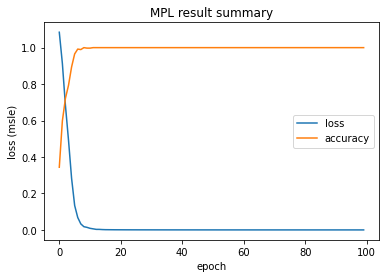

In [49]:
loss_df_mlp = pd.DataFrame(mlp_tuned_model_history.history)
loss_df_mlp.plot()
plt.title('MPL result summary')
plt.ylabel('loss (msle)')
plt.xlabel('epoch')

In [50]:
y_pred_onehot = mlp_best_model.predict(X_test)
predect_string_mlp_best = one_hot_encoder.inverse_transform(y_pred_onehot)
accuracy_tuned_mlp = accuracy_score(y_test_string, predect_string_mlp_best)
print('Accuracy for tuned MLP model is:', accuracy_tuned_mlp)
print('precision',precision_score(y_test_string, predect_string_mlp_best, average=None))
print('recall',recall_score(y_test_string, predect_string_mlp_best, average=None))

Accuracy for tuned MLP model is: 0.9876543209876543
precision [1.         0.98360656 0.98181818]
recall [0.9787234  1.         0.98181818]


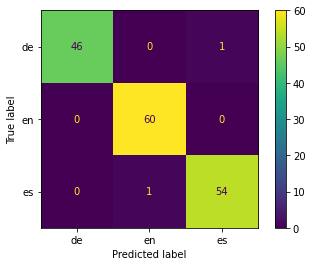

In [51]:
cm_mlp_best = confusion_matrix(y_test_string, predect_string_mlp_best,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp_best, display_labels=['de','en','es'])
disp.plot()

In [52]:
mlp_saved = "webapp/models/mlp"
mlp_best_model.save(mlp_saved)

INFO:tensorflow:Assets written to: webapp/models/mlp\assets


### LSTM

In [53]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import ELU

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X_train_lstm.shape

(378, 1, 17)

In [54]:
y_train_onehot

,x0_de,x0_en,x0_es
164,1.0,0.0,0.0
441,0.0,0.0,1.0
504,0.0,0.0,1.0
363,0.0,0.0,1.0
33,1.0,0.0,0.0
...,...,...,...
99,1.0,0.0,0.0
399,0.0,0.0,1.0
394,0.0,0.0,1.0
65,1.0,0.0,0.0


In [55]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1,17)))
lstm_model.add(Dropout(0.3))
lstm_model.add(ELU(6))
lstm_model.add(Dropout(0.3)) 
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_history = lstm_model.fit(X_train_lstm, y_train_onehot, validation_split=0.1, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
7/7 - 2s - loss: 1.0925 - accuracy: 0.4382 - val_loss: 0.9984 - val_accuracy: 0.5789 - 2s/epoch - 282ms/step
Epoch 2/100
7/7 - 0s - loss: 1.0224 - accuracy: 0.4853 - val_loss: 0.9003 - val_accuracy: 0.6579 - 47ms/epoch - 7ms/step
Epoch 3/100
7/7 - 0s - loss: 0.9145 - accuracy: 0.5882 - val_loss: 0.8154 - val_accuracy: 0.6842 - 48ms/epoch - 7ms/step
Epoch 4/100
7/7 - 0s - loss: 0.8316 - accuracy: 0.6529 - val_loss: 0.7487 - val_accuracy: 0.7368 - 50ms/epoch - 7ms/step
Epoch 5/100
7/7 - 0s - loss: 0.7735 - accuracy: 0.7147 - val_loss: 0.6919 - val_accuracy: 0.7368 - 44ms/epoch - 6ms/step
Epoch 6/100
7/7 - 0s - loss: 0.6972 - accuracy: 0.7324 - val_loss: 0.6445 - val_accuracy: 0.7895 - 47ms/epoch - 7ms/step
Epoch 7/100
7/7 - 0s - loss: 0.6348 - accuracy: 0.7971 - val_loss: 0.6031 - val_accuracy: 0.7895 - 50ms/epoch - 7ms/step
Epoch 8/100
7/7 - 0s - loss: 0.6192 - accuracy: 0.7794 - val_loss: 0.5647 - val_accuracy: 0.7895 - 51ms/epoch - 7ms/step
Epoch 9/100
7/7 - 0s - loss: 0.5

Epoch 69/100
7/7 - 0s - loss: 0.0594 - accuracy: 0.9941 - val_loss: 0.0344 - val_accuracy: 1.0000 - 42ms/epoch - 6ms/step
Epoch 70/100
7/7 - 0s - loss: 0.0563 - accuracy: 0.9912 - val_loss: 0.0326 - val_accuracy: 1.0000 - 44ms/epoch - 6ms/step
Epoch 71/100
7/7 - 0s - loss: 0.0657 - accuracy: 0.9882 - val_loss: 0.0313 - val_accuracy: 1.0000 - 44ms/epoch - 6ms/step
Epoch 72/100
7/7 - 0s - loss: 0.0605 - accuracy: 0.9882 - val_loss: 0.0299 - val_accuracy: 1.0000 - 42ms/epoch - 6ms/step
Epoch 73/100
7/7 - 0s - loss: 0.0597 - accuracy: 0.9941 - val_loss: 0.0288 - val_accuracy: 1.0000 - 39ms/epoch - 6ms/step
Epoch 74/100
7/7 - 0s - loss: 0.0609 - accuracy: 0.9853 - val_loss: 0.0280 - val_accuracy: 1.0000 - 42ms/epoch - 6ms/step
Epoch 75/100
7/7 - 0s - loss: 0.0520 - accuracy: 0.9882 - val_loss: 0.0270 - val_accuracy: 1.0000 - 41ms/epoch - 6ms/step
Epoch 76/100
7/7 - 0s - loss: 0.0479 - accuracy: 0.9971 - val_loss: 0.0254 - val_accuracy: 1.0000 - 45ms/epoch - 6ms/step
Epoch 77/100
7/7 - 0s - 

In [56]:
y_pred_onehot = lstm_model.predict(X_test_lstm)
predect_string_lstm = one_hot_encoder.inverse_transform(y_pred_onehot)
accuracy_basic_lstm = accuracy_score(y_test_string, predect_string_lstm)
print('Accuracy for LSTM model is:', accuracy_basic_lstm)
print('precision',precision_score(y_test_string, predect_string_lstm, average=None))
print('recall',recall_score(y_test_string, predect_string_lstm, average=None))

Accuracy for LSTM model is: 0.9876543209876543
precision [1.         1.         0.96491228]
recall [1.         0.96666667 1.        ]


In [57]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 elu (ELU)                   (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 21,187
Trainable params: 21,187
Non-trainable params: 0
_________________________________________________________________


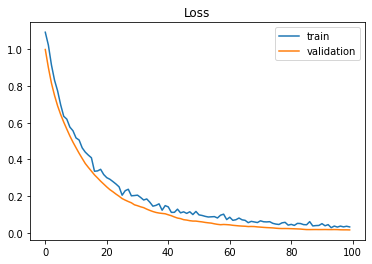

In [58]:
plt.title('Loss')
plt.plot(lstm_history.history['loss'], label='train')
plt.plot(lstm_history.history['val_loss'], label='validation')
plt.legend()
plt.show();

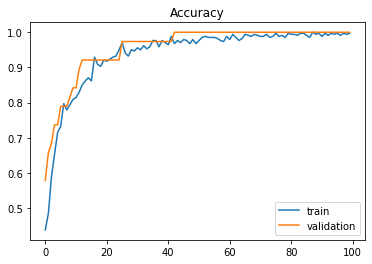

In [59]:
plt.title('Accuracy')
plt.plot(lstm_history.history['accuracy'], label='train')
plt.plot(lstm_history.history['val_accuracy'], label='validation')
plt.legend()
plt.show();

Text(0.5, 0, 'epoch')

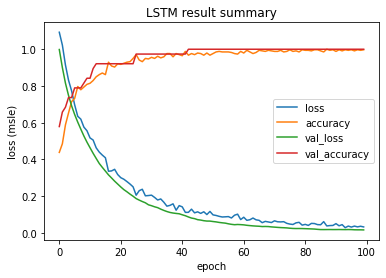

In [60]:
loss_df_mlp = pd.DataFrame(lstm_history.history)
loss_df_mlp.plot()
plt.title('LSTM result summary')
plt.ylabel('loss (msle)')
plt.xlabel('epoch')

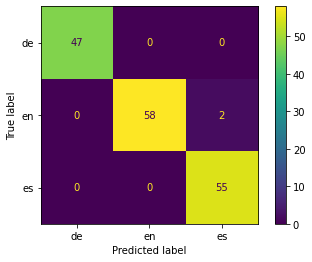

In [61]:
cm_lstm = confusion_matrix(y_test_string, predect_string_lstm,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['de','en','es'])
disp.plot()

### Tuning

In [62]:
def lstm_tuned_builder(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=17, max_value=64, step=16), activation='relu', input_shape=(1,17)))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.3, step=0.05)))
    model.add(Dense(10, activation='relu'))
    for i in range(hp.Int('layers', 0, 3)):
        model.add(ELU(6))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.3, step=0.05)))
    model.add(Dense(3, activation='softmax'))
    # Tune the learning rate in the optimizer (between 0.01, 0.001, 0.0001)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=hp_learning_rate), 
                  metrics=['accuracy'])
    return model

lstm_tuner = kt.Hyperband(lstm_tuned_builder,
                     objective='accuracy',
                     max_epochs=40,
                     directory='output/lstm_keras_tuner_dir',
                     project_name='lstm_keras_tuner0')

INFO:tensorflow:Reloading Oracle from existing project output/lstm_keras_tuner_dir\lstm_keras_tuner0\oracle.json
INFO:tensorflow:Reloading Tuner from output/lstm_keras_tuner_dir\lstm_keras_tuner0\tuner0.json


In [63]:
# tuner search the best model
lstm_tuner.search(X_train_lstm, 
      y_train_onehot,
      epochs=50,
      batch_size=30,
      validation_split=0.1,
      callbacks = [keras.callbacks.TensorBoard("/IT351_project/logs/tb_lstm_logs")],
      verbose=2)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Get the tuner summary
lstm_tuner.results_summary()

INFO:tensorflow:Oracle triggered exit
Results summary
Results in output/lstm_keras_tuner_dir\lstm_keras_tuner0
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 49
Dropout_rate: 0.0
layers: 1
learning_rate: 0.01
tuner/epochs: 14
tuner/initial_epoch: 5
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0034
Score: 1.0
Trial summary
Hyperparameters:
input_unit: 49
Dropout_rate: 0.05
layers: 3
learning_rate: 0.01
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0047
Score: 1.0
Trial summary
Hyperparameters:
input_unit: 49
Dropout_rate: 0.0
layers: 1
learning_rate: 0.01
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0046
Score: 1.0
Trial summary
Hyperparameters:
input_unit: 49
Dropout_rate: 0.05
layers: 1
learning_rate: 0.01
tuner/epochs: 40
tuner/initial_epoch: 14
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0067
Score: 1.0
Trial summary
Hyperparameters:
input_unit: 33
Dropout_rate: 0.1
layer

In [64]:
lstm_best_model = tuner.get_best_models()[0]
lstm_best_model.build(X_train_lstm.shape)
lstm_best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                306       
                                                                 
 dense_1 (Dense)             (None, 11)                198       
                                                                 
 dense_2 (Dense)             (None, 11)                132       
                                                                 
 dense_3 (Dense)             (None, 3)                 36        
                                                                 
Total params: 672
Trainable params: 672
Non-trainable params: 0
_________________________________________________________________


In [65]:
lstm_best_model.fit(
    X_train, 
    y_train_onehot,
    epochs=70,
    batch_size=50,
    validation_split=0.1,
    verbose=1)

Epoch 1/70
7/7 [==============================] - 0s 23ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.1287 - val_accuracy: 0.9737
Epoch 2/70
7/7 [==============================] - 0s 6ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9737
Epoch 3/70
7/7 [==============================] - 0s 6ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.9737
Epoch 4/70
7/7 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0667 - val_accuracy: 0.9737
Epoch 5/70
7/7 [==============================] - 0s 5ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0659 - val_accuracy: 0.9737
Epoch 6/70
7/7 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0738 - val_accuracy: 0.9737
Epoch 7/70
7/7 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0814 - val_accuracy: 0.9737
Epoch 8/70
7/7 [=================

7/7 [==============================] - 0s 5ms/step - loss: 1.2610e-04 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 0.9737
Epoch 59/70
7/7 [==============================] - 0s 6ms/step - loss: 1.2286e-04 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9737
Epoch 60/70
7/7 [==============================] - 0s 6ms/step - loss: 1.2029e-04 - accuracy: 1.0000 - val_loss: 0.0431 - val_accuracy: 0.9737
Epoch 61/70
7/7 [==============================] - 0s 5ms/step - loss: 1.1736e-04 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9737
Epoch 62/70
7/7 [==============================] - 0s 6ms/step - loss: 1.1487e-04 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9737
Epoch 63/70
7/7 [==============================] - 0s 6ms/step - loss: 1.1170e-04 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9737
Epoch 64/70
7/7 [==============================] - 0s 6ms/step - loss: 1.0932e-04 - accuracy: 1.0000 - val_loss: 0.0418 - val_accuracy: 0.9737
Epoch 65/70

In [66]:
y_pred_onehot = lstm_best_model.predict(X_test)
predect_string_lstm= one_hot_encoder.inverse_transform(y_pred_onehot)
accuracy_basic_lstm = accuracy_score(y_test_string, predect_string_lstm)
print('Accuracy for LSTM model is:', accuracy_basic_lstm)
print('precision',precision_score(y_test_string, predect_string_lstm, average=None))
print('recall',recall_score(y_test_string, predect_string_lstm, average=None))

Accuracy for LSTM model is: 0.9814814814814815
precision [1.         1.         0.94827586]
recall [0.9787234  0.96666667 1.        ]


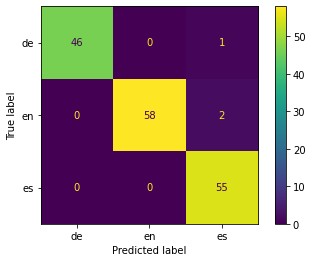

In [67]:
cm_lstm_best = confusion_matrix(y_test_string, predect_string_lstm,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm_best, display_labels=['de','en','es'])
disp.plot()

In [68]:
lstm_model_saved = "webapp/models/lstm"
lstm_model.save(lstm_model_saved)

INFO:tensorflow:Assets written to: webapp/models/lstm\assets


INFO:tensorflow:Assets written to: webapp/models/lstm\assets


# Testing

In [69]:
# load models
loaded_model_svm = pickle.load(open("webapp/models/svm.sav", 'rb'))
loaded_model_mlp = keras.models.load_model("webapp/models/mlp")
loaded_model_lstm = keras.models.load_model("webapp/models/lstm")

In [70]:
result_lstm = loaded_model_lstm.predict(X_test_lstm)
predicted_string_lstm= one_hot_encoder.inverse_transform(result_lstm)

result_mlp = loaded_model_mlp.predict(X_test)
predicted_string_mlp= one_hot_encoder.inverse_transform(result_mlp)

result_svm = loaded_model_svm.predict(X_test)

LSTM
accuracy 0.9876543209876543
precision [1.         1.         0.96491228]
recall [1.         0.96666667 1.        ]
accuracy each class [1.         0.96666667 1.        ]


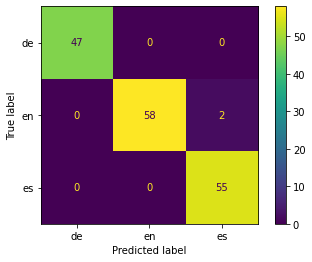

In [71]:
print('LSTM')
acc_LSTM = accuracy_score(y_test_string, predicted_string_lstm)
print('accuracy',acc_LSTM)
print('precision',precision_score(y_test_string, predicted_string_lstm, average=None))
print('recall',recall_score(y_test_string, predicted_string_lstm, average=None))

cm_lstm = confusion_matrix(y_test_string, predicted_string_lstm,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['de','en','es'])
disp.plot()
cm_lstm = cm_lstm.astype('float') / cm_lstm.sum(axis=1)[:, np.newaxis]
each_lstm = cm_lstm.diagonal()
print('accuracy each class',each_lstm)

MLP
accuracy 0.9876543209876543
precision [1.         0.98360656 0.98181818]
recall [0.9787234  1.         0.98181818]
accuracy each class [0.9787234  1.         0.98181818]


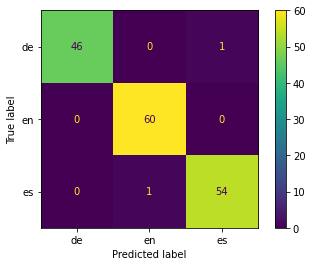

In [72]:
print('MLP')
acc_MLP = accuracy_score(y_test_string, predicted_string_mlp)
print('accuracy',acc_MLP)
print('precision',precision_score(y_test_string, predicted_string_mlp, average=None))
print('recall',recall_score(y_test_string, predicted_string_mlp, average=None))

cm_mlp = confusion_matrix(y_test_string, predicted_string_mlp,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['de','en','es'])
disp.plot()
cm_mlp = cm_mlp.astype('float') / cm_mlp.sum(axis=1)[:, np.newaxis]
each_mlp = cm_mlp.diagonal()
print('accuracy each class',each_mlp)

SVM
accuracy 0.9753086419753086
precision [0.94       1.         0.98181818]
recall [1.         0.95       0.98181818]
accuracy each class [1.         0.95       0.98181818]


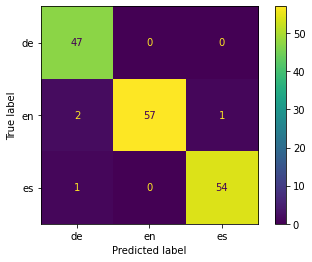

In [73]:
print('SVM')
acc_SVM = accuracy_score(y_test_string, result_svm)
print('accuracy',acc_SVM)
print('precision',precision_score(y_test_string, result_svm, average=None))
print('recall',recall_score(y_test_string, result_svm, average=None))

cm_SVM = confusion_matrix(y_test_string, result_svm,labels=['de','en','es'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_SVM, display_labels=['de','en','es'])
disp.plot()
cm_SVM = cm_SVM.astype('float') / cm_SVM.sum(axis=1)[:, np.newaxis]
each_SVM = cm_SVM.diagonal()
print('accuracy each class',each_SVM)